In [2]:
from IPython.display import HTML, display
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import umap.umap_ as umap
import pandas as pd
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "animation.embed_limit": 100
})

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

In [3]:
# Transformer models
mm_swin_cand = pd.read_csv("embedding_cands/mm_swinv2_playful_star_48_v11_N100.csv", index_col=None)
swinv2_cand = pd.read_csv("embedding_cands/swinv2_magic_plant_37_v11_N100.csv", index_col=None)

# CNN models
mm_cnn_cand = pd.read_csv("embedding_cands/mm_cnn_prod_v10_N100.csv", index_col=None)
cnn_cand = pd.read_csv("embedding_cands/cnn_effortless_butterfly_905_v10_N100.csv", index_col=None)

# MLP models
# mdata_cand = pd.read_csv("embedding_cands/mdata_swept_deluge_897_v10_N30.csv", index_col=None)


In [4]:
def plot_umap_embedding(
    cand, color_col=None, colormap='viridis', s=5, alpha=1.0,
    figsize=(10, 8), title=None, colorbar_label=False, ax=None
):
    if ax is None:
        fig, ax = plt.figure(figsize=figsize), plt.gca()
    
    embedding = cand[['umap_emb_1', 'umap_emb_2']].to_numpy()
    
    # If labels are provided, use them for coloring
    if color_col is not None:
        if color_col == "source_set":
            source_set_unique = cand["source_set"].unique()
            source_set_map = {label: i for i, label in enumerate(source_set_unique)}
            color_col_values = cand["source_set"].map(source_set_map)
        else:
            color_col_values = cand[color_col]
        
        scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                             c=color_col_values, cmap=colormap, s=s, alpha=alpha)
        if colorbar_label:
            cbar = plt.colorbar(scatter, ax=ax)
            if isinstance(colorbar_label, bool):
                colorbar_label_str = color_col
            else:
                colorbar_label_str = colorbar_label
            cbar.set_label(colorbar_label_str)
            
            if color_col == "source_set" and ax.collections:
                scatter_plot = ax.collections[0]
                # Check if the scatter plot has an associated colorbar
                if hasattr(scatter_plot, 'colorbar') and scatter_plot.colorbar is not None:
                    cb = scatter_plot.colorbar
                    
                    # Set the ticks to be the integer values 0, 1, ..., n_unique_labels-1
                    ticks = np.arange(len(source_set_unique))
                    cb.set_ticks(ticks)
                    
                    # Set the tick labels to be the original string values
                    cb.set_ticklabels(source_set_unique)
    else:
        ax.scatter(embedding[:, 0], embedding[:, 1], s=s, alpha=alpha)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_axis_off()
    # ax.set_xlabel('UMAP_1')
    # ax.set_ylabel('UMAP_2')
    
    if title:
        ax.set_title(title)
    
    return ax

In [5]:
def plot_umap_classes(
    cand, class_col=None, colors:list=None, s=5, alpha=1.0,
    figsize=(8, 8), title:str=None, xlabel:str=None, ylabel:str=None,
    inset_pos='top', ax=None
):
    n_classes = len(np.unique(cand[class_col]))
    scale = 1 / n_classes
    
    if ax is None:
        fig, ax = plt.figure(figsize=figsize), plt.gca()
    if colors is None:
        colors = [None] * n_classes

    all_embeddings = cand[['umap_emb_1', 'umap_emb_2']].to_numpy()

    for i, c in enumerate(np.unique(cand[class_col])):
        class_embeddings = cand.loc[cand[class_col]==c, ['umap_emb_1', 'umap_emb_2']].to_numpy()

        ax.scatter(class_embeddings[:, 0], class_embeddings[:, 1],
                    color=colors[i], s=s, alpha=alpha)

        if inset_pos == 'top':
            ins = ax.inset_axes([0 + (scale * i), 1, scale, scale])
        elif inset_pos == 'bottom':
            ins = ax.inset_axes([0 + (scale * i), -scale, scale, scale])
            
        ins.scatter(all_embeddings[:, 0], all_embeddings[:, 1], s=0.01, color=f'lightgray', alpha=0.1)
        ins.scatter(class_embeddings[:, 0], class_embeddings[:, 1], s=0.01, color=colors[i], alpha=0.3)

        ins.set_xticks([])
        ins.set_yticks([])

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlabel, size=24)
    ax.set_ylabel(ylabel, size=24)
    ax.set_title(title, size=24)

    return ax

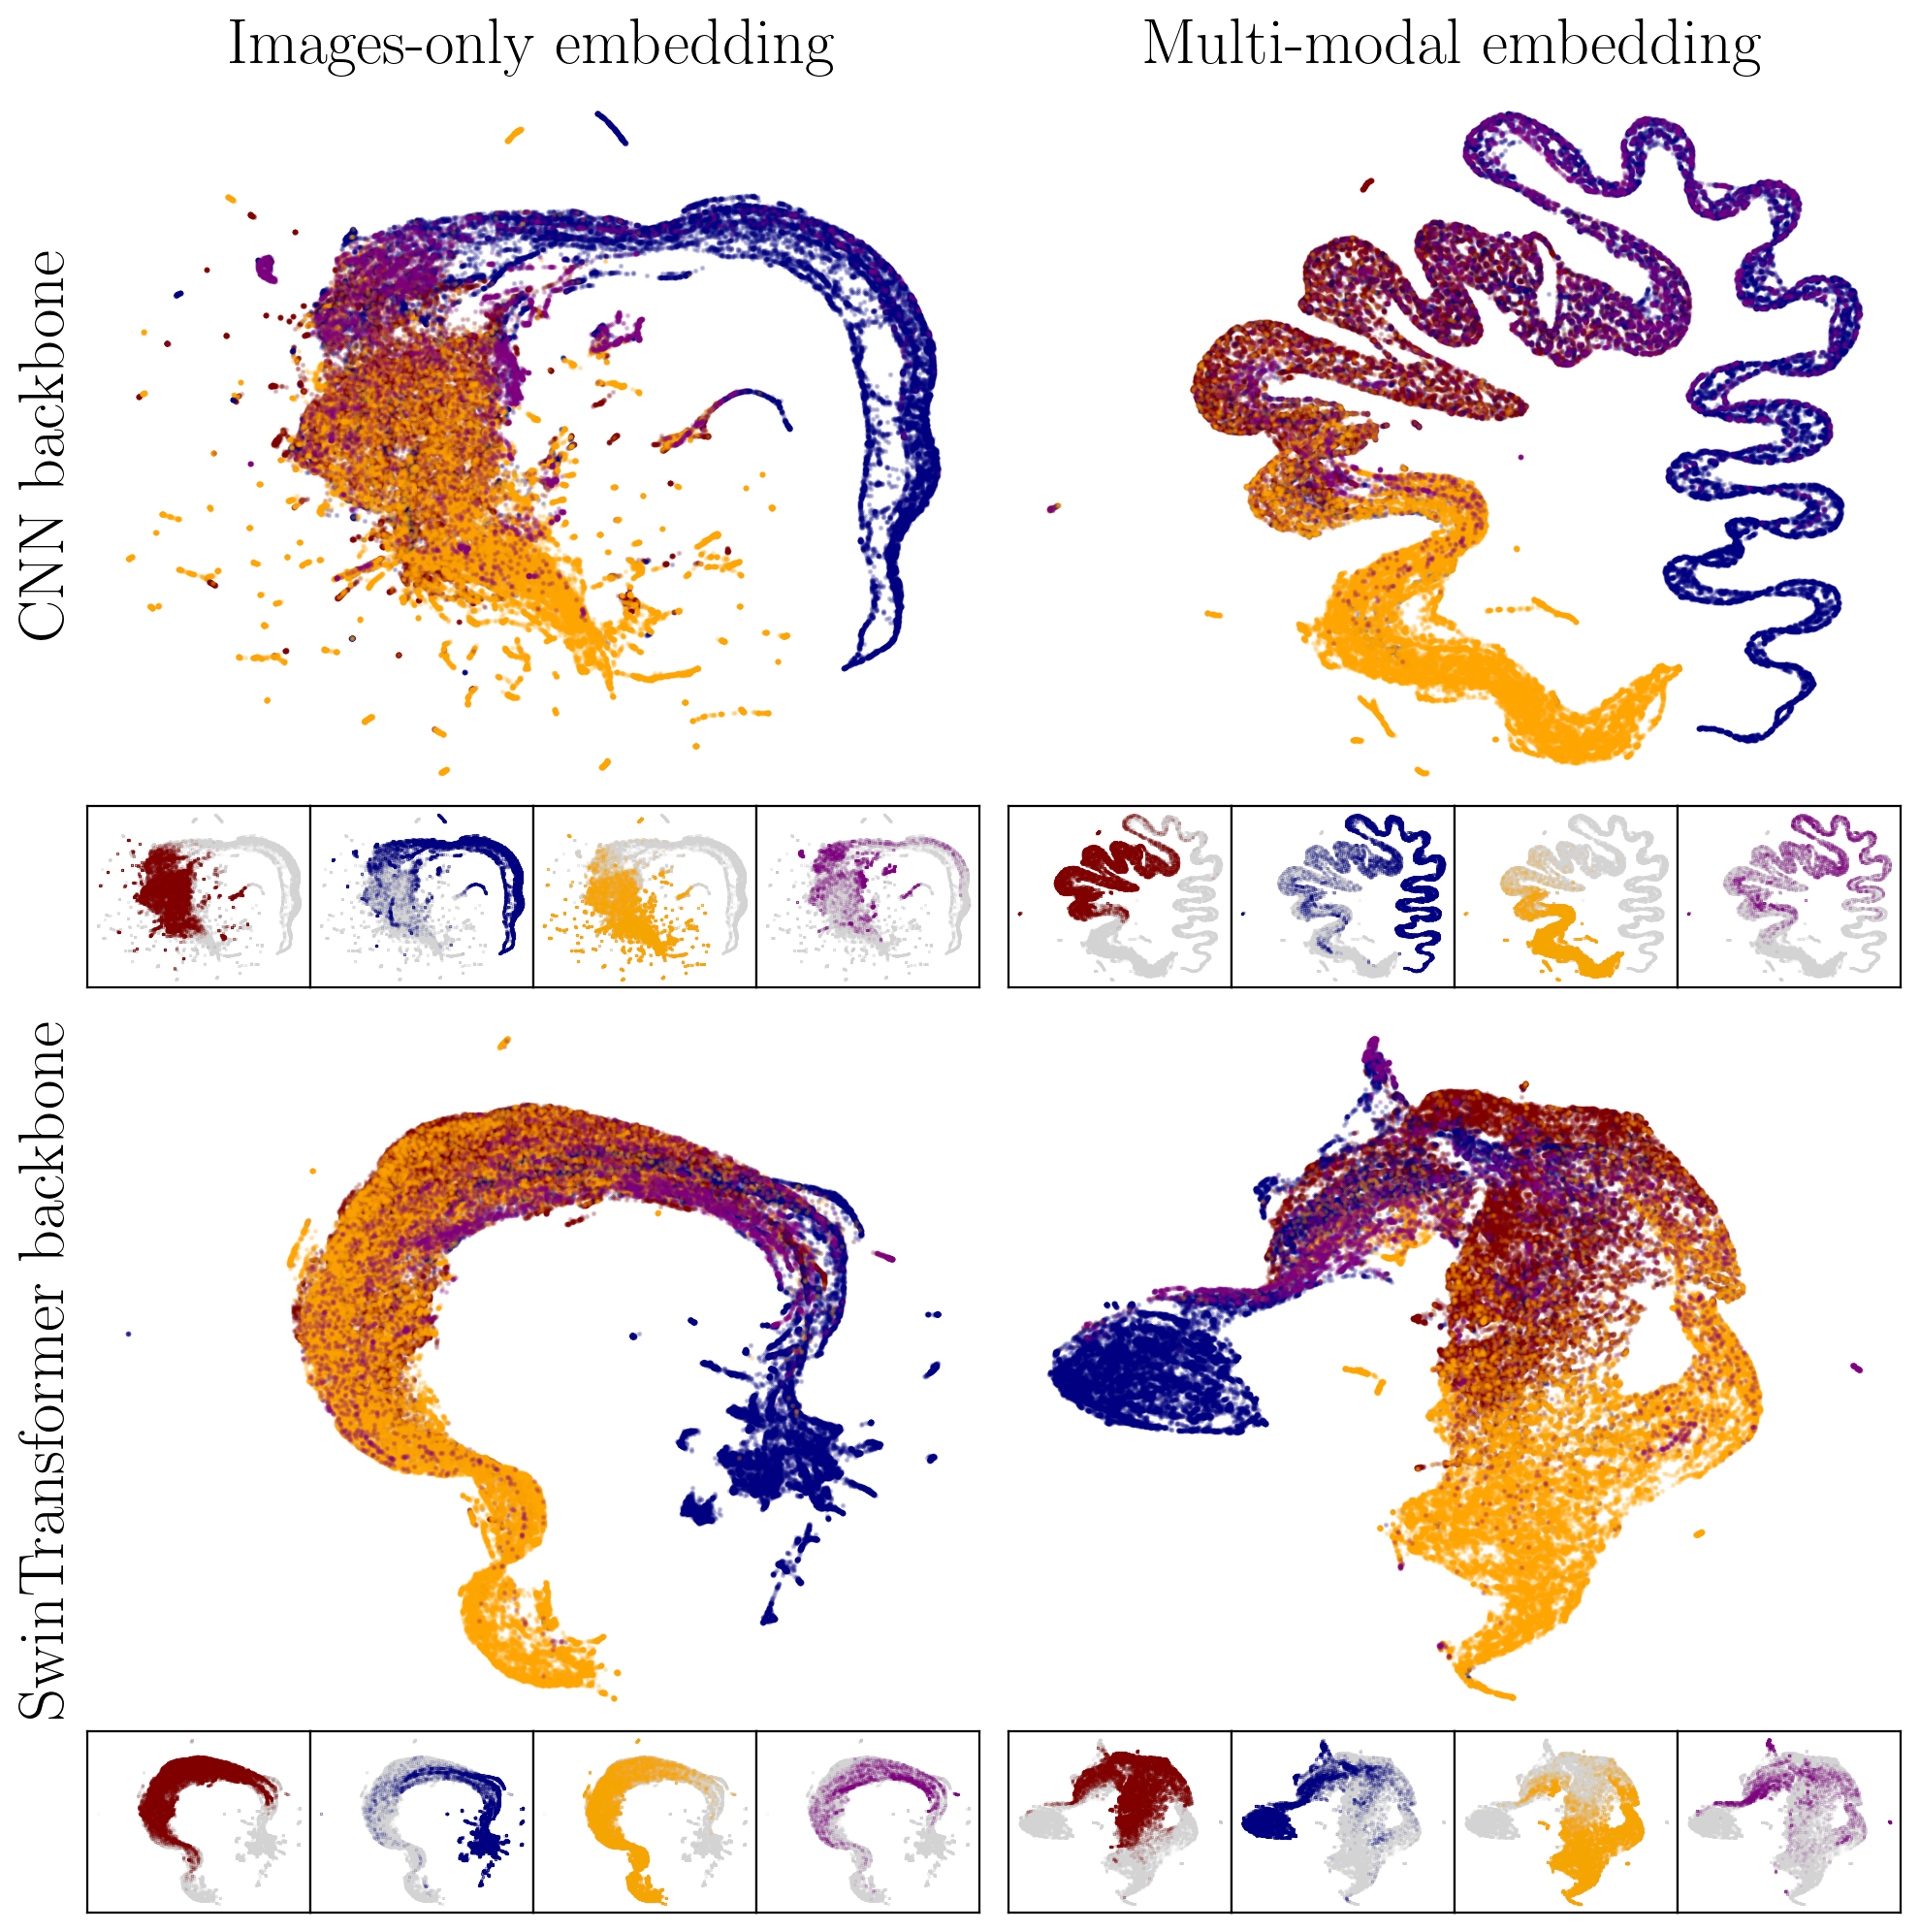

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Top left: mm_cnn_cand
ax = plot_umap_classes(
    mm_cnn_cand, 
    class_col='source_set',
    colors=['maroon', 'navy', 'orange', 'purple'],
    s=1, alpha=0.2,
    title='Multi-modal embedding',
    inset_pos='bottom', ax=axes[0,1]
)

# Top right: cnn_cand
plot_umap_classes(
    cnn_cand,
    class_col='source_set', 
    colors=['maroon', 'navy', 'orange', 'purple'],
    s=1, alpha=0.2,
    title='Images-only embedding', ylabel='CNN backbone',
    inset_pos='bottom', ax=axes[0,0]
)

# Bottom left: mm_swin_cand
plot_umap_classes(
    mm_swin_cand,
    class_col='source_set',
    colors=['maroon', 'navy', 'orange', 'purple'],
    s=1, alpha=0.2,
    inset_pos='bottom', ax=axes[1,1]
)

# Bottom right: swinv2_cand
plot_umap_classes(
    swinv2_cand,
    class_col='source_set',
    colors=['maroon', 'navy', 'orange', 'purple'],
    s=1, alpha=0.2,
    ylabel='SwinTransformer backbone',
    inset_pos='bottom', ax=axes[1,0]
)

plt.tight_layout()
plt.savefig('figs/latent_space_figs/latent_space.png', dpi=300, bbox_inches='tight')
plt.show()


<Axes: >

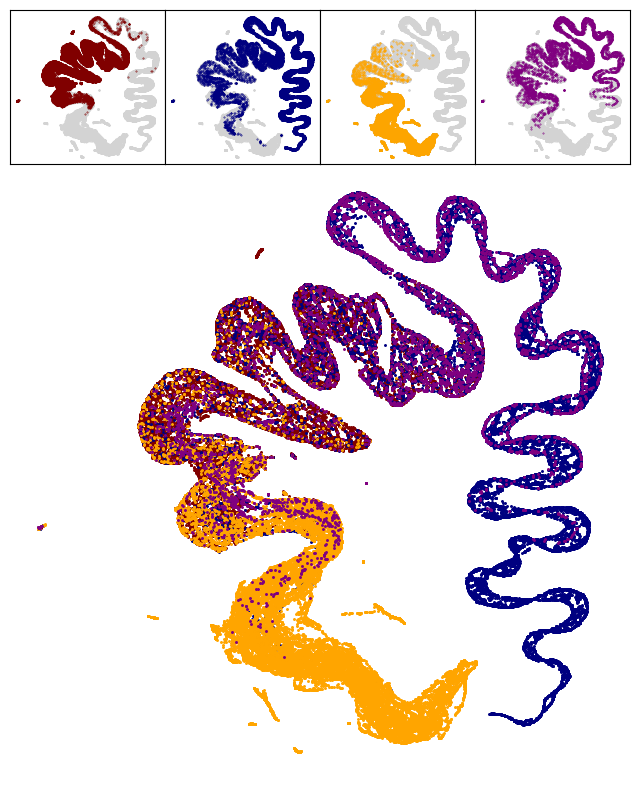

In [39]:
plot_umap_classes(mm_cnn_cand, class_col='source_set', colors=['maroon', 'navy', 'orange', 'purple'])

<Axes: >

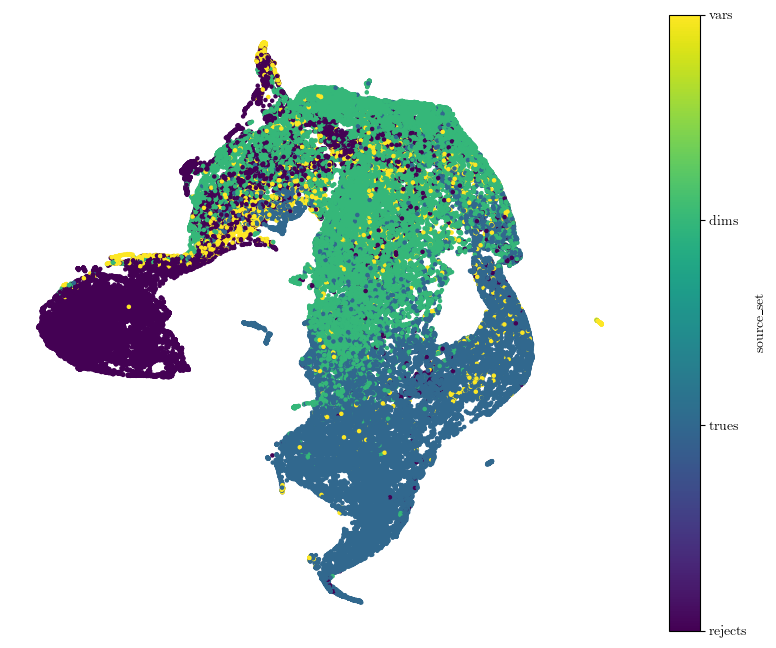

In [13]:
plot_umap_embedding(
    mm_swin_cand, color_col="source_set", colorbar_label=True
)